# Experimentation of Detecting Phishing Links



```bash
conda create --name phisherman python=3.10 -y
conda activate phisherman
pip3 install numpy==1.26.4 pandas matplotlib scikit-learn seaborn evaluate
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 -y
python -m pip install "tensorflow<2.11"
pip3 install transformers[torch]
```

## Dataset Things

Dataset:
- https://data.mendeley.com/datasets/vfszbj9b36/1
- https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset
- https://www.kaggle.com/datasets/harisudhan411/phishing-and-legitimate-urls
- https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Concatenate,
    BatchNormalization,
    Bidirectional,
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM

import os
import requests
import zipfile
import os

In [2]:
def get_dataset():
    """
    Creates a folder named 'dataset' if it doesn't exist.
    :return:
        None
    """
    dest_folder_name = 'dataset'
    dest_csv_name = 'phishing_data.csv'
    csv_link = 'https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip'

    dest_folder_path = os.path.join(os.getcwd(), dest_folder_name)
    dest_file_path = os.path.join(dest_folder_path, dest_csv_name)
    dest_zip_save_path = os.path.join(dest_folder_name, "dataset.zip")


    if not os.path.exists(dest_file_path):
        # Create folder
        os.makedirs(dest_folder_path)
        # Download zip file
        zip_folder = requests.get(csv_link, stream=True)
        zip_folder.raise_for_status()

        with open(dest_zip_save_path, 'wb') as f:
            for chunk in zip_folder.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Zip file downloaded to: {dest_zip_save_path}")

        # Extract the zip file
        with zipfile.ZipFile(dest_zip_save_path, 'r') as zip_ref:
            zip_ref.extractall(dest_folder_path)
        print(f"Zip file extracted to: {dest_folder_path}")

        # Rename csv file to csv_name variable
        old_filepath = os.path.join(dest_folder_path, 'PhiUSIIL_Phishing_URL_Dataset.csv')
        os.rename(old_filepath, dest_file_path)
        print(f"File renamed to '{dest_file_path}'")
        
get_dataset()

In [3]:
phishing_df = pd.read_csv("dataset/phishing_data.csv")
phishing_df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [4]:
phishing_df = phishing_df[["URL", "label"]]
phishing_df.head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [5]:
len(phishing_df)

235795

In [6]:
phishing_df2 = pd.read_csv("dataset/dataset num 2.csv")
phishing_df2["type"] = phishing_df2["type"].apply(
    lambda x: 0 if x == "legitimate" else 1
)
phishing_df2.columns = ['URL', 'label']
phishing_df2.head()

,URL,label
0,https://www.google.com,0
1,https://www.youtube.com,0
2,https://www.facebook.com,0
3,https://www.baidu.com,0
4,https://www.wikipedia.org,0


In [7]:
len(phishing_df2)

450176

In [8]:
phishing_df3 = pd.read_csv("dataset/new_data_urls.csv")
phishing_df3.columns = ["URL", "label"]
phishing_df3.head()

,URL,label
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [9]:
phishing_df4 = pd.read_csv("dataset/phishing_site_urls.csv")
phishing_df4.columns = ["URL", "label"]
phishing_df4["label"] = phishing_df4["label"].apply(
    lambda x: 1 if x == "bad" else 0
)
phishing_df4.head()

,URL,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [10]:
# Bad only
phishing_df4_bad = phishing_df4[phishing_df4['label'] == 1]
phishing_df4_bad['label'].value_counts()

label
1    156422
Name: count, dtype: int64

In [11]:
df_combined = pd.concat(
    [phishing_df, phishing_df2, phishing_df3, phishing_df4_bad],
    ignore_index=True,
)

In [12]:
df_combined.to_csv('./dataset/final_dataset.csv',index=False)

In [13]:
df_combined.head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [14]:
len(df_combined)

1664403

In [15]:
phishing_df = df_combined

## Data Exploration

In [16]:
phishing_df_url_labels = phishing_df[['URL', 'label']]

In [17]:
phishing_df_url_labels[phishing_df_url_labels["label"] == 0].head()

,URL,label
11,http://www.teramill.com,0
20,http://www.f0519141.xsph.ru,0
21,http://www.shprakserf.gq,0
27,https://service-mitld.firebaseapp.com/,0
28,http://www.kuradox92.lima-city.de,0


In [18]:
phishing_df_url_labels[phishing_df_url_labels["label"] == 1].head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [19]:
phishing_df_url_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664403 entries, 0 to 1664402
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   URL     1664403 non-null  object
 1   label   1664403 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 25.4+ MB


In [20]:
check_label_counts = phishing_df_url_labels.groupby(by="label", axis=0).count()
check_label_counts.index = ['Non-Phishing', 'Phishing']

check_label_counts

C:\Users\lelop\AppData\Local\Temp\ipykernel_9124\2867867651.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  check_label_counts = phishing_df_url_labels.groupby(by="label", axis=0).count()


,URL
Non-Phishing,841665
Phishing,822738


In [21]:
# Calculate the total count
total_count = check_label_counts.sum()

# Convert counts to percentages
check_label_counts_percentage = (check_label_counts / total_count) * 100

# Display the result
check_label_counts_percentage

,URL
Non-Phishing,50.568582
Phishing,49.431418


## Spliting Train and Test set

In [22]:
X = phishing_df_url_labels['URL']
y = phishing_df_url_labels['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.84, random_state=42, stratify=y, train_size=0.16,shuffle=True
)

In [23]:
# pd.DataFrame({"url": X_train, "label":y_train}).to_csv("dataset_mini.csv", index=False)

In [24]:
len(X_train)

266304

In [25]:
len(X_test)

1398099

## Experimenting with Simple AI Architectures

### Data Processing

In [24]:
# Initialize tokenizer with an OOV token.
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1  # plus one for padding token
sequences = tokenizer.texts_to_sequences(X_train)
max_length = max(len(seq) for seq in sequences)

In [25]:
def convert_url_padding(data):
    # Convert URLs to sequences and pad them
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")
    return padded_sequences

### Creating a CNN Model

In [26]:
def create_cnn_model(vocab_size, embedding_dim, input_length):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, mask_zero=True)(inputs)

    # A 1D convolution layer to capture n-gram features
    x = Conv1D(filters=128, kernel_size=7, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Binary classification output
    output_class = Dense(1, activation='sigmoid', name='binary_class')(x)
    model = Model(inputs, output_class)
    return model

# Create the CNN model
embedding_dim = 128  # You can experiment with this size
cnn_model = create_cnn_model(vocab_size, embedding_dim, input_length=max_length)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitors validation loss
    patience=2,  # Stops if loss doesn't improve for 5 epochs
    restore_best_weights=True,  # Restores model to best weights when stopped
    verbose=1,
)

cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4274)]            0         
                                                                 
 embedding (Embedding)       (None, 4274, 128)         29696     
                                                                 
 conv1d (Conv1D)             (None, 4268, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

### Creating a RNN Model

In [ ]:
def create_rnn_model(vocab_size, embedding_dim, input_length):
    inputs = Input(shape=(input_length,))
    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=input_length,
        mask_zero=True,
    )(inputs)
    
    # Bidirectional LSTM to capture both forward and backward dependencies
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Binary classification output
    output_class = Dense(1, activation="sigmoid", name="binary_class")(x)

    model = Model(inputs, output_class)
    return model


# Create the RNN model
rnn_model = create_rnn_model(
    vocab_size, embedding_dim, input_length=max_length
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model.compile(
    optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"]
)
# rnn_model.summary()

### Training 

In [27]:
X_train_encoding = convert_url_padding(X_train)
X_test_encoding = convert_url_padding(X_test)

In [28]:
history_cnn = cnn_model.fit(
    X_train_encoding,
    y_train,
    epochs=6,
    validation_split=0.3,
    batch_size=32,
    callbacks=[early_stopping],
)

# history_rnn = rnn_model.fit(
#     X_train_encoding,
#     y_train,
#     epochs=1,
#     validation_split=0.3,
#     batch_size=32,
# )

Epoch 1/6
5826/5826 [==============================] - 97s 16ms/step - loss: 0.2876 - accuracy: 0.8755 - val_loss: 0.2482 - val_accuracy: 0.8884
Epoch 2/6
5826/5826 [==============================] - 90s 15ms/step - loss: 0.2503 - accuracy: 0.8868 - val_loss: 0.2442 - val_accuracy: 0.8872
Epoch 3/6
5826/5826 [==============================] - 91s 16ms/step - loss: 0.2375 - accuracy: 0.8899 - val_loss: 0.2289 - val_accuracy: 0.8924
Epoch 4/6
5826/5826 [==============================] - 90s 16ms/step - loss: 0.2269 - accuracy: 0.8918 - val_loss: 0.2297 - val_accuracy: 0.8915
Epoch 5/6
5826/5826 [==============================] - 90s 15ms/step - loss: 0.2194 - accuracy: 0.8936 - val_loss: 0.2364 - val_accuracy: 0.8924
Epoch 5: early stopping


In [29]:
y_pred = cnn_model.predict(X_test_encoding)

43691/43691 [==============================] - 185s 4ms/step


In [55]:
y_pred_int = (y_pred > 0.5).astype(int)

In [56]:
accuracy_score(y_test, y_pred_int)

0.8913438890951213

In [57]:
cnn_model.predict(
    convert_url_padding(
        [
            "https://www.southbankmosaics.com",
            "http://activate.facebook.fblogins.net/88adbao798283o8298398?login.asp",
            "http://www.buy.com.money.ru",
            "http://jhomitevd2abj3fk.onion.to/",
            "premierpaymentprocessing.com/includes/boleto-2via-07-2012.php",
            "scamme.com",
            "stealyourmoney.com",
            "paynow.paypay.com",
            "https://pornhut.com",
            "https://paypalll.com",
            "https://google.loginnnn.com",
            "https://facebook.com"
        ]
    )
) > 0.1

1/1 [==============================] - 0s 24ms/step


array([[ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

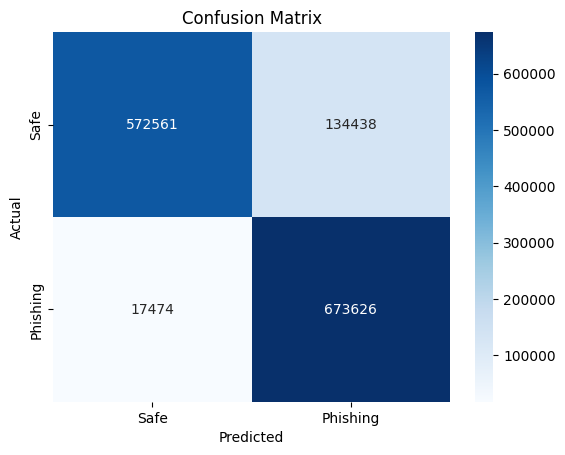

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_int)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [59]:
precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
f1 = f1_score(y_test, y_pred_int)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8336
Recall: 0.9747
F1 Score: 0.8987


## Using BERT

In [62]:
import torch
from transformers import DistilBertTokenizerFast, BertTokenizerFast
from datasets import Dataset


tokenizer = BertTokenizerFast.from_pretrained(
    "CrabInHoney/urlbert-tiny-v3-phishing-classifier"
)

In [63]:
def tokenize_function(data):
    return tokenizer(
        data["text"], padding="max_length", truncation=True, max_length=64
    )

In [64]:
# Get val set
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,  
    stratify=y_train
)

In [65]:
len(X_train_new)

199728

In [66]:
len(X_val)

66576

In [67]:
train_df = pd.DataFrame(
    {
        "text": X_train_new.tolist(),
        "label": y_train_new.tolist(),
    }
)
val_df = pd.DataFrame(
    {
        "text": X_val.tolist(),
        "label": y_val.tolist(),
    }
)

In [68]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [69]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/199728 [00:00<?, ? examples/s]

Map:   0%|          | 0/66576 [00:00<?, ? examples/s]

In [70]:
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

In [71]:
train_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)
val_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "label"]
)

In [72]:
from transformers import AutoModelForSequenceClassification

In [73]:
model = AutoModelForSequenceClassification.from_pretrained(
    "CrabInHoney/urlbert-tiny-v3-phishing-classifier",
    torch_dtype="auto",
    num_labels=len(y_train_new.unique()),
)

In [74]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="best",
    load_best_model_at_end=True,
    tf32=True
)

In [75]:
import numpy as np
import evaluate

In [76]:
metric = evaluate.load("accuracy")

In [77]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [78]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [79]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.245200,0.258211,0.882976
2,0.231900,0.258157,0.888999


TrainOutput(global_step=49932, training_loss=0.2784254216335145, metrics={'train_runtime': 2478.3567, 'train_samples_per_second': 161.178, 'train_steps_per_second': 20.147, 'total_flos': 551707612618752.0, 'train_loss': 0.2784254216335145, 'epoch': 2.0})

In [50]:
# Set model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [52]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def predict(text):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move input tensors to device


    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and apply softmax for probabilities
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    return {
        "predicted_class": predicted_class,
        "probabilities": probabilities.tolist(),
    }


# Example usage
text = "This is an amazing product!"  # Replace with any text
prediction = predict(text)
print(prediction)

{'predicted_class': 0, 'probabilities': [[0.9432583451271057, 0.05674164369702339]]}


In [54]:
metric = evaluate.load("accuracy")

In [ ]:
test_df = pd.DataFrame({"text": X_test.tolist(), "labels": y_test.tolist()})
test_dataset = Dataset.from_pandas(test_df)


test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove original text column and set format for PyTorch
test_dataset = test_dataset.remove_columns(["text"])
test_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

Map:   0%|          | 0/1398099 [00:00<?, ? examples/s]

In [ ]:
def evaluate_model(test_dataset):
    predictions = []
    references = []

    from torch.utils.data import DataLoader

    test_dataloader = DataLoader(test_dataset, batch_size=16)

    with torch.no_grad():
        for batch in test_dataloader:
            # Move batch to the correct device
            batch = {key: val.to(device) for key, val in batch.items()}

            # Forward pass
            outputs = model(
                **batch
            )  # Ensure batch contains 'labels' instead of 'label'
            logits = outputs.logits
            preds = torch.argmax(logits, axis=-1)

            # Store predictions and actual labels
            predictions.extend(preds.cpu().numpy())
            references.extend(
                batch["labels"].cpu().numpy()
            )  # Use 'labels' instead of 'label'

    # Compute accuracy
    accuracy = metric.compute(predictions=predictions, references=references)
    return accuracy


# Run evaluation
accuracy_result = evaluate_model(test_dataset)
print("Accuracy:", accuracy_result)